In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn  as sns 
from scipy import fft, signal, stats



In [2]:
gear_data = pd.read_csv('gear_data.csv')
gear_data = gear_data[['a1','a2', 'a3', 'a4', 'load','broken']]
gear_data.insert(0, 'sample_index', range(0, len(gear_data)))

In [3]:
gear_data.sample(3, random_state=40)

,sample_index,a1,a2,a3,a4,load,broken
1014090,1014090,-20.38600,3.54584,-1.493790,-7.76892,90,0
1082904,1082904,1.91490,-1.18980,0.669235,-5.73093,0,1
43902,43902,-3.97368,-1.12817,0.602861,3.53260,0,0


In [4]:
sensors = gear_data.melt(
    id_vars = ['sample_index', 'load', 'broken'], 
    value_vars=['a1', 'a2', 'a3', 'a4'], #Sospetto che il sensore numero 1 abbia un qualche tipo di bias 
    #pesante che varia da quando siamo in stato 'Healthy' a 'Broken Tooth'
    var_name='sensor',
    value_name='reading'
)

<AxesSubplot: xlabel='count', ylabel='load'>

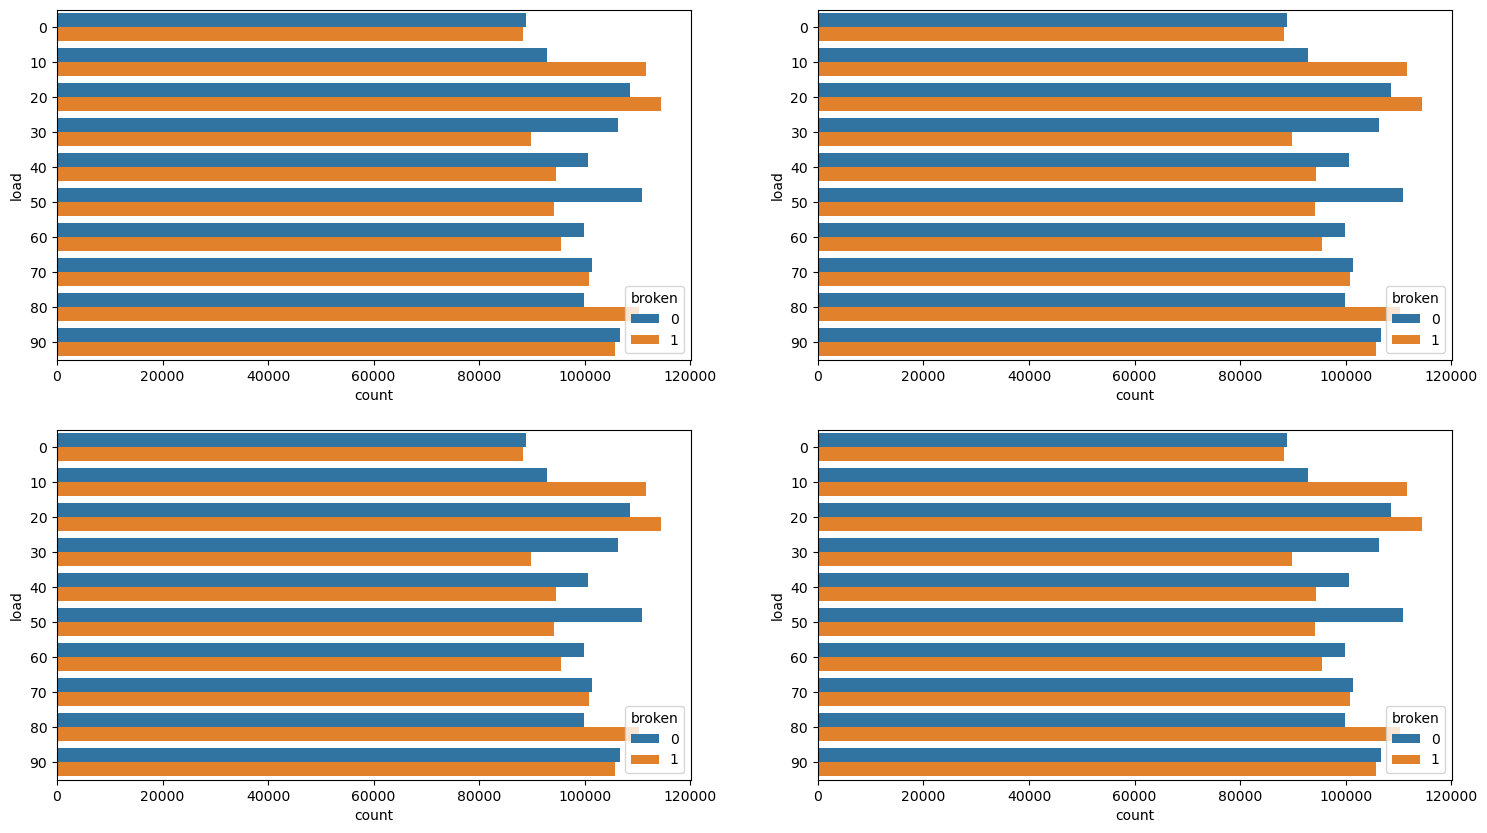

In [5]:
fig, axes = plt.subplots(2,2, figsize= (18, 10))
sns.countplot(
    ax = axes[0,0],
    data = sensors[sensors.sensor=='a2'], 
    y='load',
    hue='broken',
)

sns.countplot(
    ax = axes[0,1],
    data = sensors[sensors.sensor=='a2'],
    y='load',
    hue = 'broken',
)
sns.countplot(
    ax=axes[1,0],
    data = sensors[sensors.sensor == 'a3'],
    y='load',
    hue = 'broken',
)
sns.countplot(
    ax=axes[1,1],
    data = sensors[sensors.sensor == 'a4'],
    y='load',
    hue='broken',   
)


In [6]:
sensor1Load0 = sensors.loc[(sensors.sensor=='a1') & (sensors.load == 0)]
sensor1Load90 = sensors.loc[(sensors.sensor=='a1') & (sensors.load == 90)]

sensor2Load0 = sensors.loc[(sensors.sensor=='a2') & (sensors.load == 0)]
sensor2Load90 = sensors.loc[(sensors.sensor=='a2') & (sensors.load == 90)]

sensor3Load0 = sensors.loc[(sensors.sensor=='a3') & (sensors.load == 0)]
sensor3Load90 = sensors.loc[(sensors.sensor=='a3') & (sensors.load == 90)]

sensor4Load0 = sensors.loc[(sensors.sensor=='a4') & (sensors.load == 0)]
sensor4Load90 = sensors.loc[(sensors.sensor=='a4') & (sensors.load == 90)]


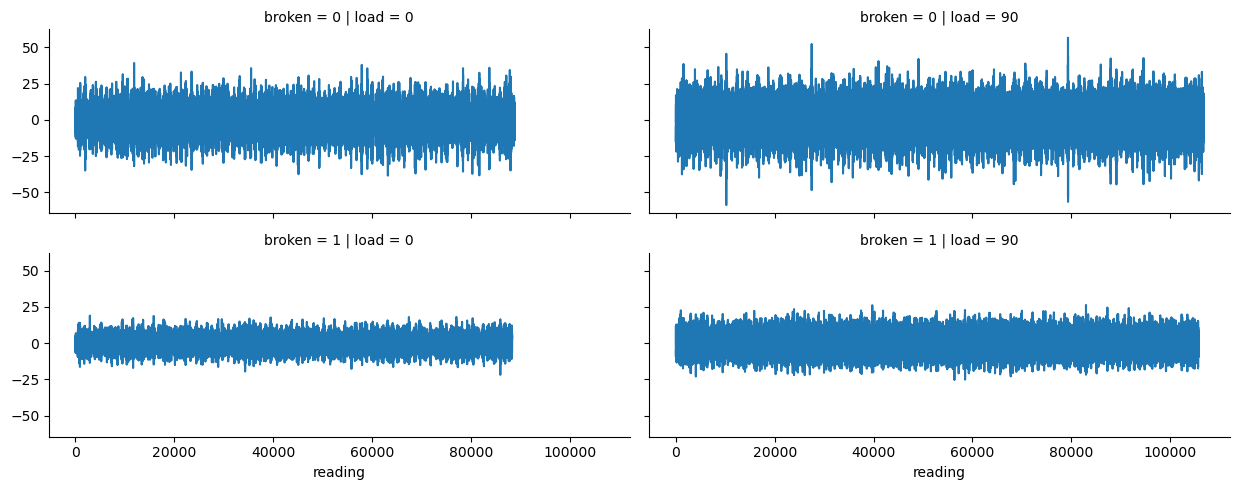

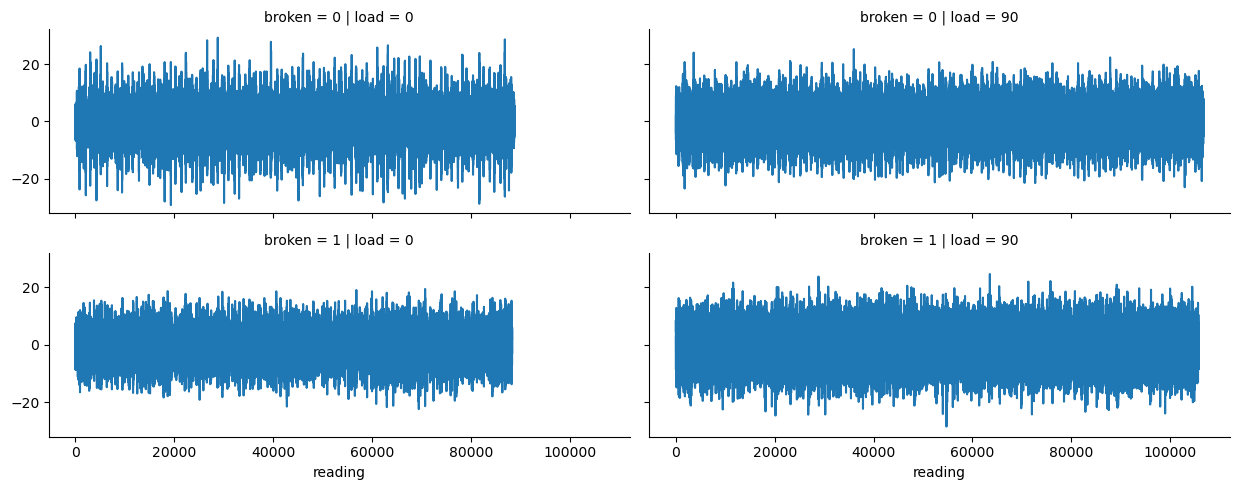

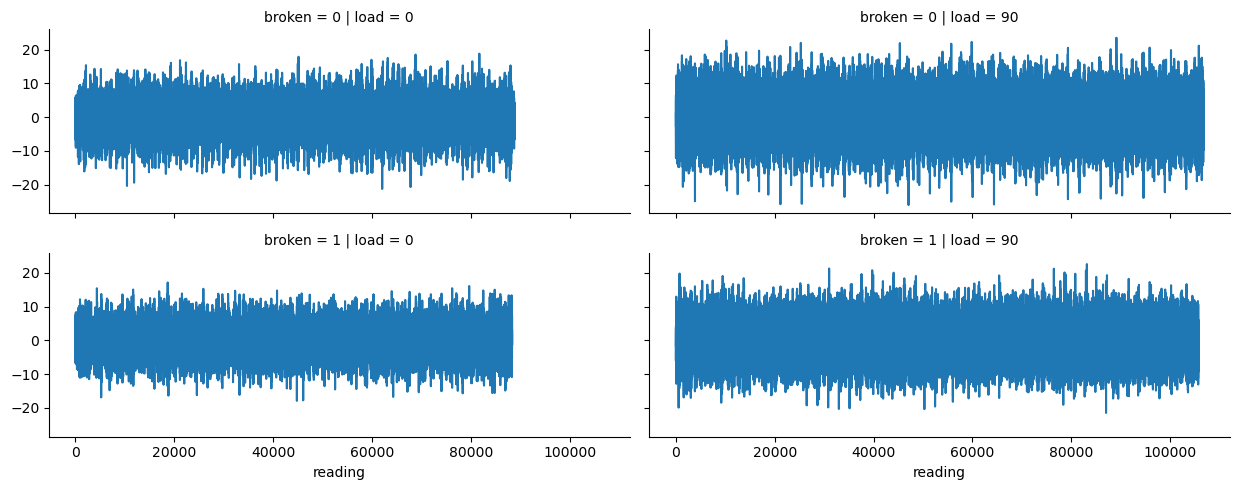

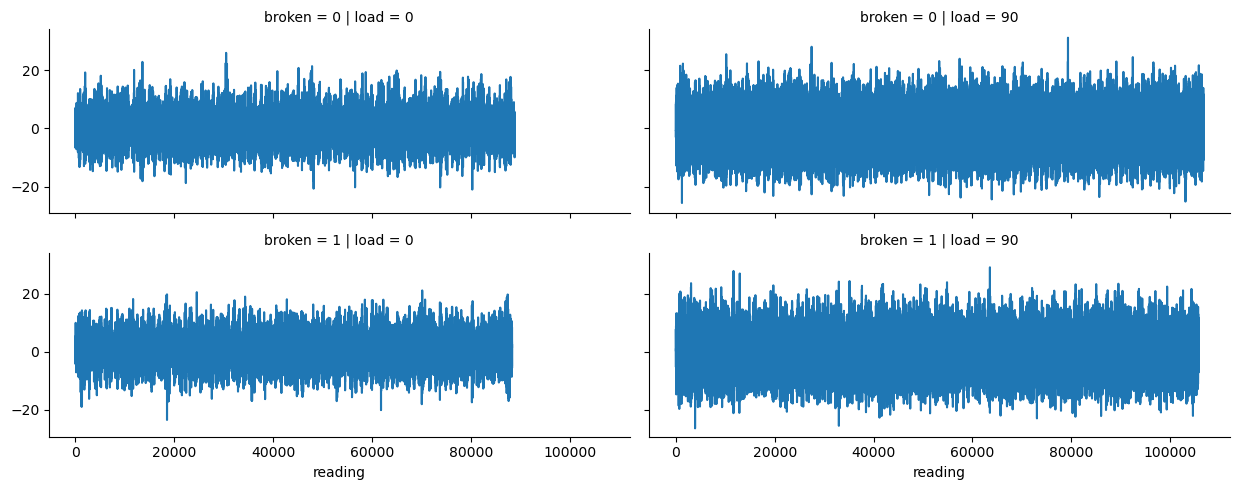

In [7]:
## Sensore A1
g = sns.FacetGrid(
    data = pd.concat([sensor1Load0, sensor1Load90]),
    col = 'load',
    row = 'broken',
    height=2.5,
    aspect=2.5,
)

## Sensore A2
h = sns.FacetGrid( 
    data = pd.concat([sensor2Load0, sensor2Load90]),
    col = 'load',
    row = 'broken',
    height=2.5,
    aspect=2.5,
)

## Sensore A3

i = sns.FacetGrid( 
    
    data = pd.concat([sensor3Load0, sensor3Load90]),
    col = 'load',
    row = 'broken',
    height=2.5,
    aspect=2.5,
)

## Sensore A4
j = sns.FacetGrid( 
    data = pd.concat([sensor4Load0, sensor4Load90]),
    col = 'load',
    row = 'broken',
    height=2.5,
    aspect=2.5,
)
g.map(plt.plot, 'reading')
h.map(plt.plot, 'reading')
i.map(plt.plot, 'reading')
j.map(plt.plot, 'reading')
plt.show()

## Conclusioni intermedie:
È subito visibile come il sensore **a1** presenti una differenza molto marcata tra i valori di vibrazione *Healthy* e i valori di vibrazione *Broken*. In particolare il sensore rileva vibrazioni molto minori nel momento in cui viene a rompersi il dente di uno degli ingranaggi all'interno del gearbox. 
Nonostante questa differenza sembri essere presente anche nelle letture degl´i altri sensori, essa risulta essere molto meno marcata. 
Qualcosa di simile

In [8]:
sns.catplot(
    data = sensors,
    col = 'load', row = 'sensor', # Nel plot ogni riga è un sensore, ognni colonna rappresenta il Carico aumentante da 0 a 90
    x = 'broken', y = 'reading', # Con il colore Arancione abbiamo sempre la condizione di Broken, con il Blu la condizione di Healthy
    kind='boxen',
    height = 20, 
)

In [9]:
# Eliminiamo il sensore 1 per quello che abbiamo esposto in precedenza 
polished_data = sensors[sensors.sensor != 'a1']

<AxesSubplot: xlabel='reading', ylabel='Count'>

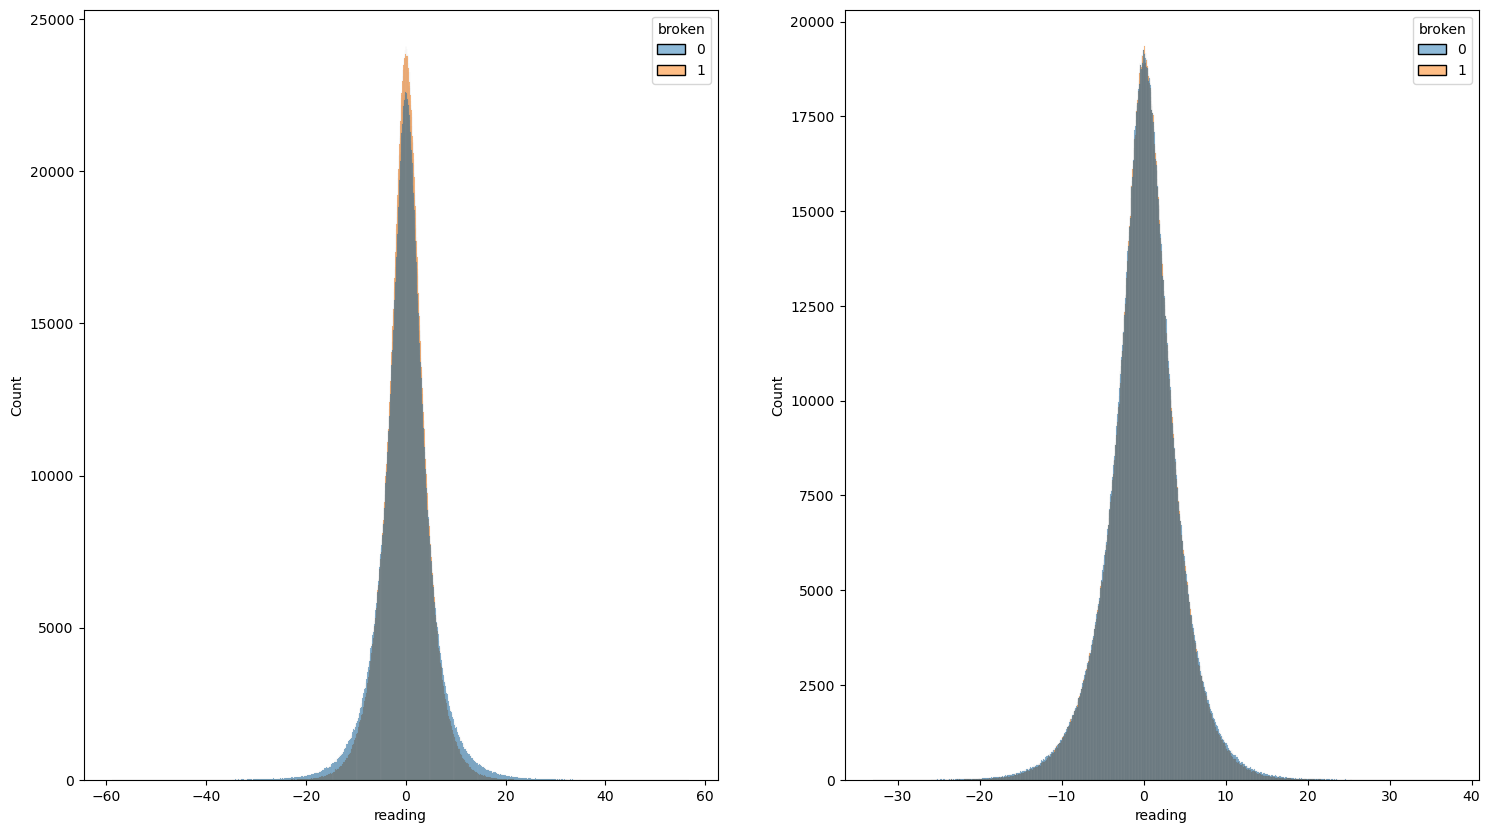

In [10]:
fig, axes = plt.subplots(1,2, figsize= (18, 10))
sns.histplot(
    ax = axes[0],
    data = sensors, 
    hue = 'broken', 
    x = 'reading'
)



sns.histplot(
    ax = axes[1],
    data = polished_data, 
    hue = 'broken', 
    x = 'reading'
)

In [11]:
## Calcolo la deviazione standard con e senza il sensore a1
display(sensors.groupby(['sensor','broken']).reading.std().unstack())
display(polished_data.groupby(['sensor', 'broken']).reading.std().unstack())

print(f"Deviazione standard del sensore a1 {sensors.loc[sensors.sensor == 'a1'].groupby(['sensor','broken']).reading.std()}")

print(f"Deviazione standard includendo a1 {sensors.reading.std()}")
print(f"Deviazione standard escludendo a1: {polished_data.reading.std()}")

broken,0,1
sensor,,
a1,7.381206,4.602696
a2,4.427153,4.389516
a3,4.110277,3.808909
a4,4.523553,4.408367


broken,0,1
sensor,,
a2,4.427153,4.389516
a3,4.110277,3.808909
a4,4.523553,4.408367


Deviazione standard del sensore a1 sensor  broken
a1      0         7.381206
        1         4.602696
Name: reading, dtype: float64
Deviazione standard includendo a1 4.822152445519395
Deviazione standard escludendo a1: 4.285349925978674


Bisogna trovare una maniera per generare delle feature che siano utilizzabili in un contesto di machine learning che non richiedano una esagerata potenza di calcolo, a differenza dell'approccio che utilizza ***tsfresh*** 

## Analisi nel dominio della frequenza
Convertiamo utilizzando la trasformata di fourier per poter vedere le cose sotto il punto di vista della frequenza

In [12]:
#Prendiamo i dati del sensore a4 con carico 10 in condizioni "Healthy"
sensor4_data_healthy10 = sensors.loc[(sensors.sensor == 'a4') & (sensors.load == 10) & (sensors.broken == 0)].reading.values

shape dei sensor data 92928
46465 numero totale di "frequency points"


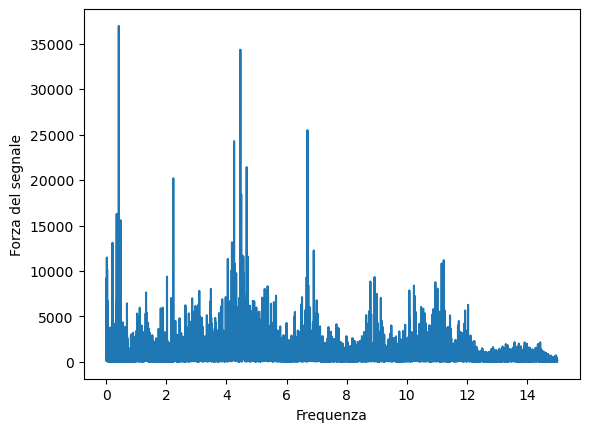

In [13]:
y = np.abs(fft.rfft(sensor4_data_healthy10))
print(f'shape dei sensor data {sensor4_data_healthy10.shape[0]}')
x = fft.rfftfreq(sensor4_data_healthy10.shape[0], 1/30)

print(f'{y.shape[0]} numero totale di "frequency points"')

plt.plot(x,y)
plt.xlabel("Frequenza")
plt.ylabel('Forza del segnale')
plt.show()

Identifichiamo i picchi 

0.41838842975206614
2.2317277892561984
3.347753099173554
4.463455578512397
5.64921229338843
6.695506198347108
7.72759555785124
8.927233987603307
10.08490444214876
11.228693181818182
{'prominences': array([36939.12284199, 20182.74281571,  5105.36410585, 34327.80522043,
        7266.55634238, 25463.37364247,  3682.17162834,  9327.70711073,
        7828.89316236, 11179.31032723]), 'left_bases': array([  917,  2577, 10025,  2577, 17202, 14814, 23742, 22492, 27919,
       27919]), 'right_bases': array([ 2577,  9445, 10415, 37960, 19177, 37960, 25857, 27919, 31374,
       37960])}


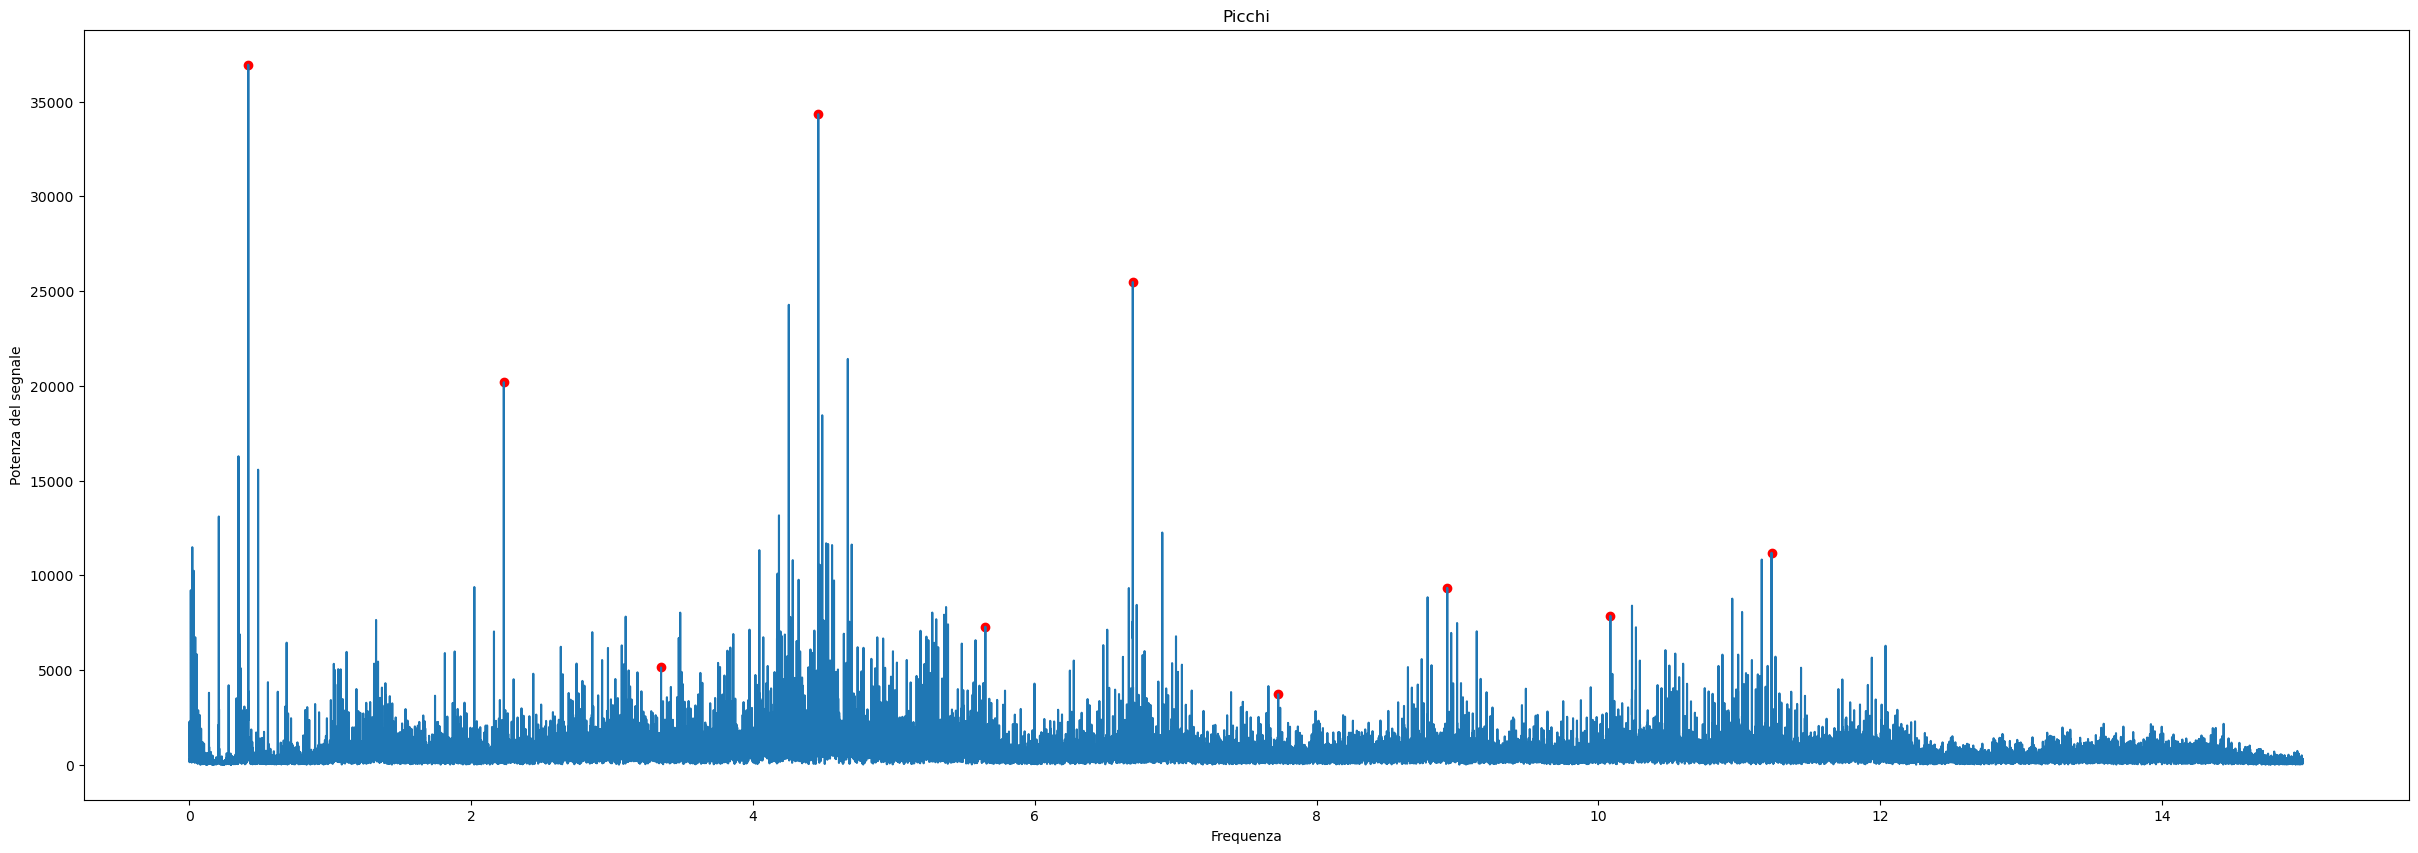

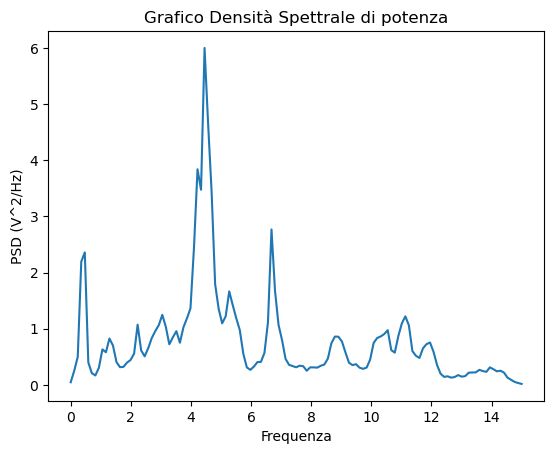

In [14]:
y = np.abs(fft.rfft(sensor4_data_healthy10))
x = fft.rfftfreq(sensor4_data_healthy10.shape[0], 1/30)
peak_space = y.shape[0] / x.max() #I picchi devono essere almeno separati da un hertz
peak_prominence = np.quantile(y,0.99)
peaks, _ = signal.find_peaks(y,distance=peak_space, prominence=peak_prominence)

for peak in peaks: 
    print(x[peak])
print(_) #In questa variabile vengono salvati 
## 1. I valori di prominenza per ogni singolo picco trovato (10 picchi in questo caso)
## 2. Le basi destre e sinistre del picco, lascio di seguito un commento che spiega come funziona 
##    la questione di left e right bases per il calcolo della prominence


# The algorithm used to determine the left and right 'bases' is illustrated below:
# - (1) extend a line to the left and right of the maximum until it reaches the window
# border (here on
# the left) or the signal (here on the right).
# - (2) find the minimum value within the intervals defined above. These
# points are the peak's bases.
# - (3) use the higher base (here the right base) and peak maximum to calculate the
# prominence.



#Plottiamo innanzitutto lo stesso grafico di poco fa ma aggiungiamo i valori dei picchi che abbiamo trovato
plt.figure(figsize=(30, 10))
plt.title("Picchi")
plt.plot(x,y)
plt.xlabel("Frequenza")
plt.ylabel("Potenza del segnale")
for peak in peaks: 
    plt.scatter(x = x[peak], y = y[peak], c = 'r')


plt.figure()
plt.title("Grafico Densità Spettrale di potenza")
plt.xlabel("Frequenza")
plt.ylabel("PSD (V^2/Hz)")
x, y = signal.welch(sensor4_data_healthy10, fs = 30)
plt.plot(x,y)
plt.show()



Dai precedenti si nota come le armoniche principali si trovino rispettivamente in [2,23; 4,46; 6,69; 8.92; 11,22]. 
Ciò ci viene confermato dal grafico della **Densità Spettrale di Potenza** 
Adesso proviamo a plottare il grafico della **PSD** per ognuno dei sensori per ogni valore di carico. 
Definisco a questo punto una funzione che sia in grado di stampare a schermo, dati i valori di healthy e broken per uno stesso carico di uno stesso sensore, il suddetto grafico. 

In [15]:
print(range(0,90,10))

range(0, 90, 10)


In [16]:
def plotPSD(healthy, broken, load, sensor,rows, cols, ax): 
    healthy = healthy.reading.values
    broken = broken.reading.values
    
    x_healthy, y_healthy = signal.welch(healthy, fs = 30)
    x_broken, y_broken  = signal.welch(broken, fs = 30)
    
    #plt.title("Densità spettrale di potenza sensore: "+str(sensor)+" a carico: "+str(load))
    ax[rows,cols].set_title("Sensore: "+str(sensor)+" carico: "+str(load))
    ax[rows, cols].plot(x_healthy,y_healthy, 'r', label="h")
    ax[rows, cols].plot(x_broken, y_broken,'b', label="b")
    ax[rows,cols].legend()
    #ax[rows, cols].xlabel("Frequenza Hz")
    #ax[rows, cols].ylabel("PSD")

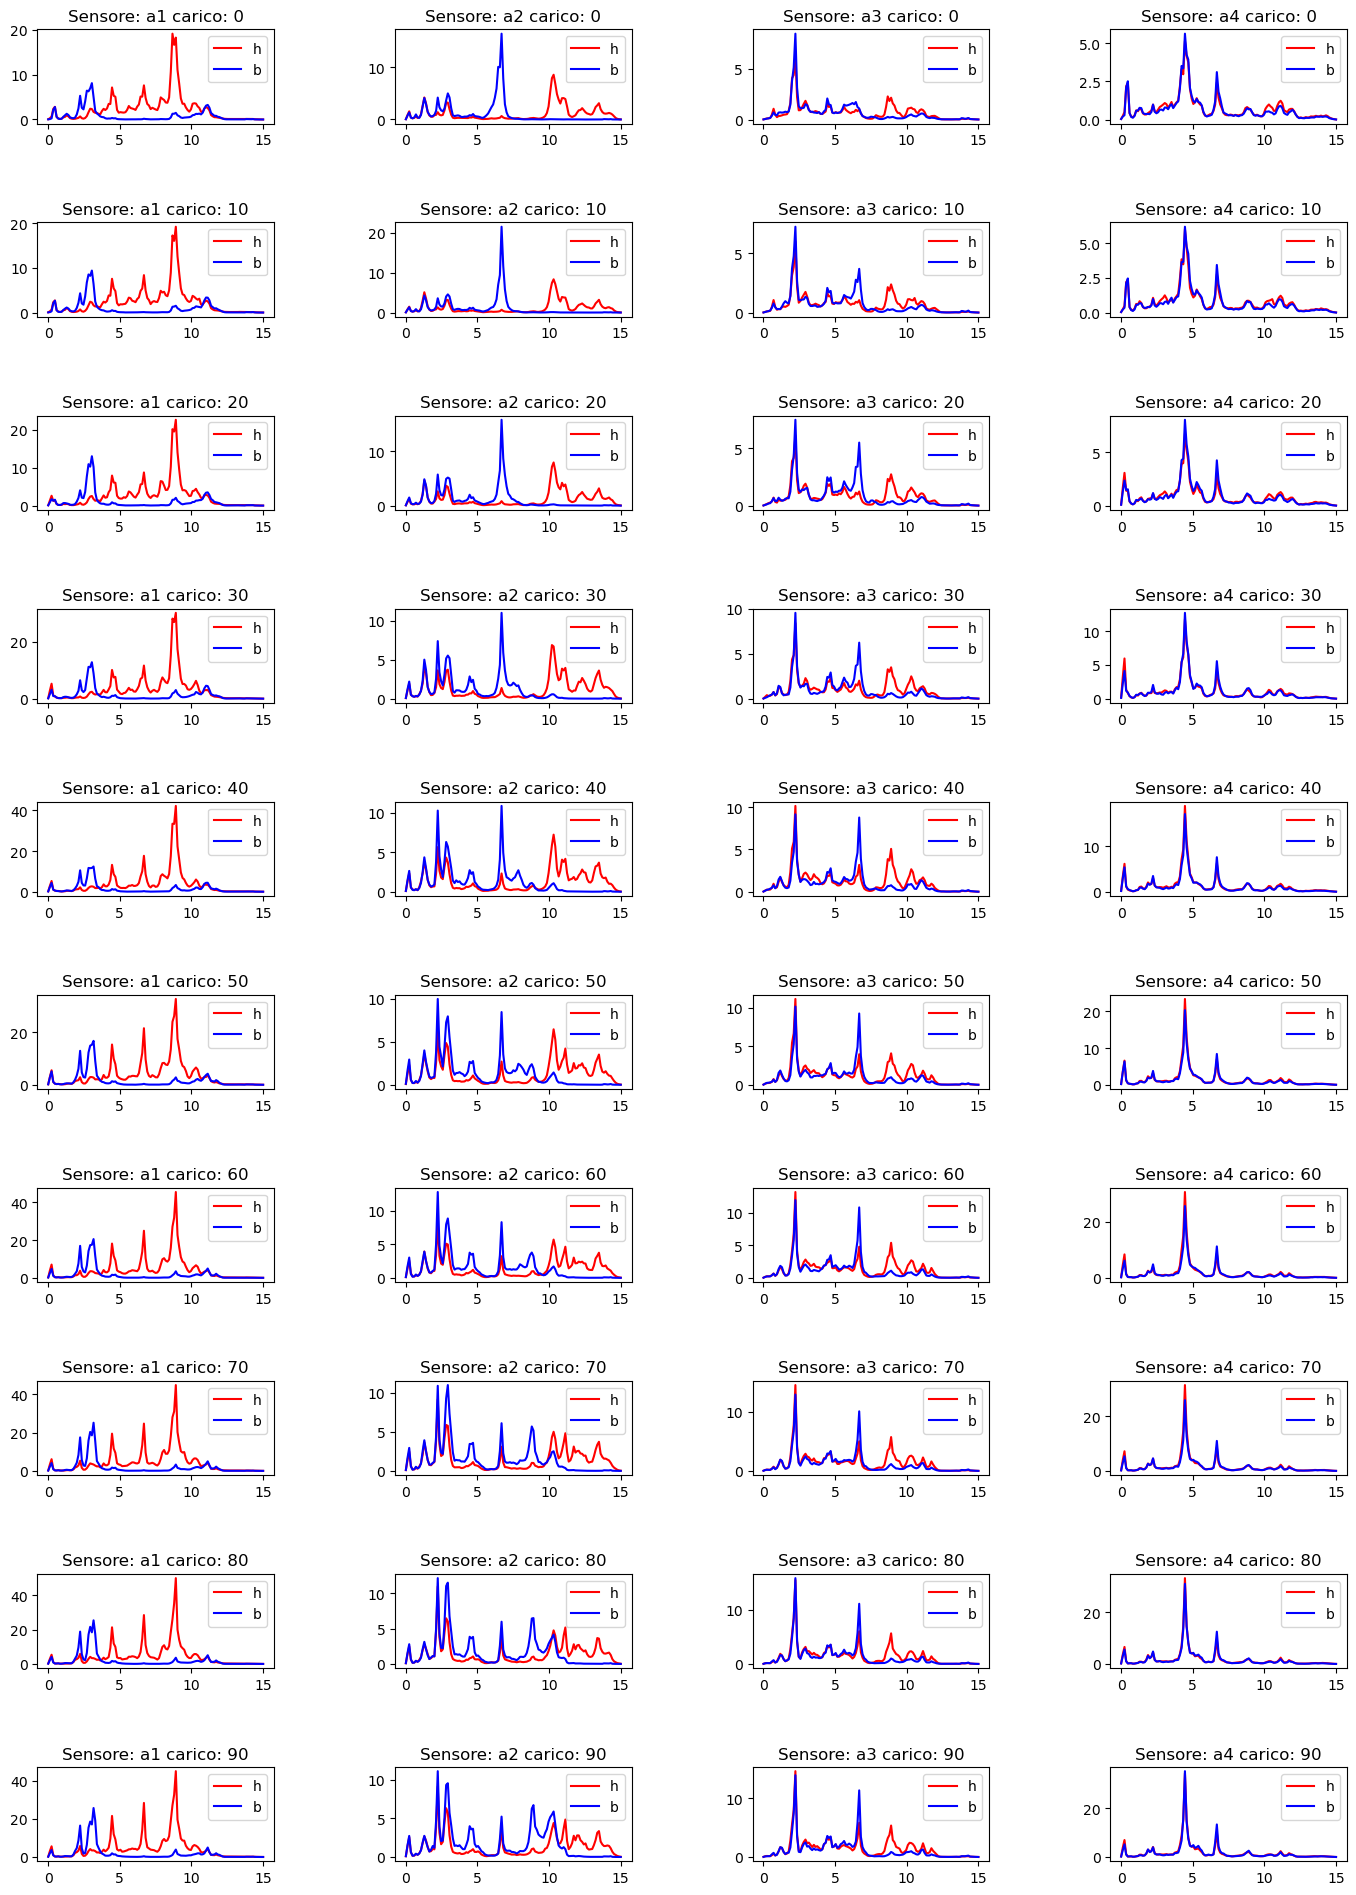

In [17]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(15,20))
fig.tight_layout(pad=5.0)
sensor_list = ["a1", "a2", "a3", "a4"]
rows = 0
cols = 0
for load in range(0, 100, 10): 
    for a in sensor_list:
        healthy = sensors.loc[(sensors.sensor == a) & (sensors.load == load)&(sensors.broken == 0)]
        broken = sensors.loc[(sensors.sensor == a)&(sensors.load == load)&(sensors.broken == 1)]
        plotPSD(healthy, broken, load, a, rows, cols, ax)
        cols += 1
        if cols == 4: 
            cols = 0
            rows += 1
         

## Deduzioni
È possibile immediatamente notare come per i sensori che vanno dall'uno al tre ci sia una notevole differenza in frequenza per quanto riguarda il caso *healthy* e il caso *broken*; l'unico sensore che non presenta una tale differenza in maniera rilevante è il sensore **a4**, il quale presenta la stessa *Distribuzione spettrale di potenza*.(In realtà si evince come anche il sensore 3 abbia delle variazioni veramente minime, ma si discosta nella sezione che va tra approssimativamente gli 8 e gli 11 Hz) **TIP: Reti bayesiane, Decision treee** 

In [18]:
'''
data = []
labels = []
for (state,load,sensor),g in sensors.groupby(['broken','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)
'''

"\ndata = []\nlabels = []\nfor (state,load,sensor),g in sensors.groupby(['broken','load','sensor']):\n    vals = g.reading.values\n    splits = np.split(vals, range(1000,vals.shape[0],1000))\n    for s in splits[:-1]:  # except the last one\n        data.append({\n            'sensor_a1': int(sensor=='a1'),\n            'sensor_a2': int(sensor=='a2'),\n            'sensor_a3': int(sensor=='a3'),\n            # no need to put a4: if a1-3 are 0, then it's sensor a4\n            'load': load,\n            'mean': np.mean(s),\n            'std': np.std(s),\n            'kurt': stats.kurtosis(s),\n            'skew': stats.skew(s),\n            'moment': stats.moment(s),\n        })\n        labels.append(int(state=='b'))  # positive label indicates fault\n\ndf_data = pd.DataFrame(data)\ndata = df_data.values\nlabels = np.array(labels)\n(data.shape, labels.shape)\n"